In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import glob
import itertools
import pandas as pd
import seaborn as sns
import pydot

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix


In [2]:
train_data_dir = r"D:/experiments/Datasets/ip102_v1.1-002/ip102_v1.1/prepared_data/train_stg/"
valid_data_dir = r"D:/experiments/Datasets/ip102_v1.1-002/ip102_v1.1/prepared_data/val_stg/"
test_data_dir = r"D:/experiments/Datasets/ip102_v1.1-002/ip102_v1.1/prepared_data/test_stg/"

In [3]:
classes = [
        'Adult',
        'Larva',
        'Pupa',
        'Egg'
]

EfficientNetV2M

In [4]:
# datagen = ImageDataGenerator(
#     # preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     vertical_flip=True,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

In [5]:
#Without data augmentation
datagen = ImageDataGenerator()

In [6]:
train_batchs_Res = datagen.flow_from_directory(directory=train_data_dir, target_size=(224,224), classes=classes,class_mode='categorical', batch_size=64)

valid_batchs_Res = datagen.flow_from_directory(directory=valid_data_dir, target_size=(224,224), classes=classes,class_mode='categorical', batch_size=64)

test_batchs_Res = datagen.flow_from_directory(directory=test_data_dir, target_size=(224,224), classes=classes,class_mode='categorical', batch_size=64, shuffle=False)

Found 38400 images belonging to 4 classes.
Found 6352 images belonging to 4 classes.
Found 20047 images belonging to 4 classes.


In [7]:
base_model_Res = EfficientNetV2M(include_top = False, weights = 'imagenet',input_shape=(224, 224, 3))

for layer in base_model_Res.layers:
    layer.trainable = True

In [8]:
x = base_model_Res.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

predictions = Dense(train_batchs_Res.num_classes, activation='softmax')(x)

modelRes = Model(inputs=base_model_Res.input, outputs=predictions)
modelRes.compile(optimizer = Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [9]:
callbacks = [
        ModelCheckpoint("SavedModels/EfficientNetV2M/EfficientNetV2M_stg_no_aug.h5", verbose=1, save_best_model=True),
        ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
        EarlyStopping(monitor="val_loss", patience=5, verbose=1)
    ]

In [10]:
history_Res = modelRes.fit(x = train_batchs_Res, 
            steps_per_epoch=train_batchs_Res.samples // 64,
            validation_data = valid_batchs_Res,
            validation_steps=valid_batchs_Res.samples // 64,
            epochs = 500, verbose = 1,
            callbacks=callbacks,
)

Epoch 1/500
600/600 [==============================] - ETA: 0s - loss: 0.1753 - accuracy: 0.9443
Epoch 1: saving model to SavedModels/EfficientNetV2M\EfficientNetV2M_stg_no_aug.h5
600/600 [==============================] - 209s 328ms/step - loss: 0.1753 - accuracy: 0.9443 - val_loss: 0.1296 - val_accuracy: 0.9654 - lr: 1.0000e-04
Epoch 2/500
600/600 [==============================] - ETA: 0s - loss: 0.0518 - accuracy: 0.9839
Epoch 2: saving model to SavedModels/EfficientNetV2M\EfficientNetV2M_stg_no_aug.h5
600/600 [==============================] - 172s 286ms/step - loss: 0.0518 - accuracy: 0.9839 - val_loss: 0.1544 - val_accuracy: 0.9648 - lr: 1.0000e-04
Epoch 3/500
600/600 [==============================] - ETA: 0s - loss: 0.0316 - accuracy: 0.9901
Epoch 3: saving model to SavedModels/EfficientNetV2M\EfficientNetV2M_stg_no_aug.h5
600/600 [==============================] - 172s 286ms/step - loss: 0.0316 - accuracy: 0.9901 - val_loss: 0.1495 - val_accuracy: 0.9669 - lr: 1.0000e-04
Epoc

In [11]:
Res_model = tf.keras.models.load_model('SavedModels/EfficientNetV2M/EfficientNetV2M_stg_no_aug.h5')

Res_predictions = Res_model.predict(x=test_batchs_Res, verbose=0)

In [12]:
y_pred_Res = np.argmax(Res_predictions, axis=1)
y_true_Res = test_batchs_Res.classes

accuracy = accuracy_score(y_true_Res, y_pred_Res)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_true_Res, y_pred_Res, average='weighted', zero_division=0)
print('Precision: %f' % precision)

recall = recall_score(y_true_Res, y_pred_Res, average='weighted', zero_division=0)
print('Recall: %f' % recall)

f1 = f1_score(y_true_Res, y_pred_Res, average='weighted', zero_division=0)
print('F1 score: %f' % f1)

print(classification_report(y_true_Res, y_pred_Res, target_names = classes))

Accuracy: 0.968374
Precision: 0.967671
Recall: 0.968374
F1 score: 0.967774
              precision    recall  f1-score   support

       Adult       0.98      0.98      0.98     16252
       Larva       0.92      0.94      0.93      3344
        Pupa       0.79      0.67      0.73       356
         Egg       0.78      0.49      0.61        95

    accuracy                           0.97     20047
   macro avg       0.87      0.77      0.81     20047
weighted avg       0.97      0.97      0.97     20047



In [13]:
#Get the filename including last folder
image_names = [os.path.basename(filename) for filename in test_batchs_Res.filenames]


# Get the image names from the ImageDataGenerator
image_names = test_batchs_Res.filenames

df = pd.DataFrame({'Image Name': image_names, 'Predicted': y_pred_Res, 'Ground Truth': y_true_Res})
df.to_csv('EfficientNetV2M_stg_no_aug.csv', index=False)

(<Figure size 400x400 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

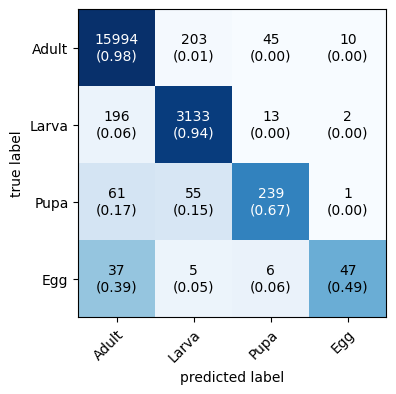

In [14]:
matRes = confusion_matrix(y_true_Res,y_pred_Res)
plot_confusion_matrix(matRes, figsize=(4,4), class_names=classes, show_normed=True)

In [15]:
import time

# Load the model
Res_model = tf.keras.models.load_model('SavedModels/EfficientNetV2M/EfficientNetV2M_stg_no_aug.h5')

# Get the number of images in the test batch
num_images = len(test_batchs_Res)

# Start the timer before prediction
start_time = time.time()

# Make predictions
Res_predictions = Res_model.predict(x=test_batchs_Res, verbose=0)

# End the timer after prediction
end_time = time.time()

# Calculate total inference time in seconds
total_inference_time = end_time - start_time

# Calculate the time per image (in seconds)
time_per_image = total_inference_time / num_images

# Convert to milliseconds for easier interpretation
time_per_image_ms = time_per_image * 1000

# Print the results
print(f"Total inference time: {total_inference_time:.2f} seconds")
print(f"Inference time per image: {time_per_image_ms:.4f} ms")

Total inference time: 29.16 seconds
Inference time per image: 92.8808 ms
